In [7]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import StandardScaler

from transformers import BertTokenizer

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow import keras
from tensorflow.keras import layers

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

#sklearn processing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#configs
max_tokens = 20000
max_length = 600

/kaggle/input/feedback-prize-english-language-learning/sample_submission.csv
/kaggle/input/feedback-prize-english-language-learning/train.csv
/kaggle/input/feedback-prize-english-language-learning/test.csv


In [2]:
sample_submission_raw = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/sample_submission.csv')
train_data_raw = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/train.csv')
test_from_comp = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/test.csv')

In [3]:
train, test = train_test_split(train_data_raw, test_size=0.2, random_state=21) #20% for test
train, val = train_test_split(train, test_size=0.1, random_state=21) # 10% for validation
train

targets=['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

sc_y = StandardScaler()
train_targets = sc_y.fit_transform(train[targets])
val_targets = sc_y.transform(val[targets])
test_targets = sc_y.transform(test[targets])

train_targets_ds = tf.convert_to_tensor(train_targets)
val_targets_ds = tf.convert_to_tensor(val_targets)
test_targets_ds = tf.convert_to_tensor(test_targets)

train_text_only = tf.convert_to_tensor(train['full_text'])
val_text_only = tf.convert_to_tensor(val['full_text'])
test_text_only = tf.convert_to_tensor(test['full_text'])


## for submission 
all_sc_y = StandardScaler()
all_train_targets = all_sc_y.fit_transform(train_data_raw[targets])
all_train_targets_ds = tf.convert_to_tensor(all_train_targets)
all_train_text_only = tf.convert_to_tensor(train_data_raw['full_text'])

all_test_text_only = tf.convert_to_tensor(test_from_comp['full_text'])


2022-11-26 21:32:12.208047: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 21:32:12.370290: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 21:32:12.371404: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 21:32:12.374825: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [17]:
# text_vectorization = layers.TextVectorization(
#     max_tokens=max_tokens,
#     output_mode="multi_hot"
# )

text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)

#use the dataset to index the dataset vocab via the adapt method
text_vectorization.adapt(train_text_only)

train_features_ds = text_vectorization(train_text_only)
val_features_ds = text_vectorization(val_text_only)
test_features_ds = text_vectorization(test_text_only)

#for submission
all_train_features_ds = text_vectorization(all_train_text_only)
all_test_features_ds = text_vectorization(all_test_text_only)


In [18]:
def get_model(max_tokens=max_tokens, hidden_dim=32):
    
    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = tf.one_hot(inputs, depth=max_tokens)
    
    x = layers.Bidirectional(layers.LSTM(32, return_sequences=False))(embedded)
    x = layers.Dropout(rate=0.5)(x)

    outputs = layers.Dense(6, activation=None)(x)
    
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="mean_absolute_error",
        metrics=[tf.keras.metrics.RootMeanSquaredError(
                name='root_mean_squared_error', dtype=None
            )]
    )
    return model

#train model and test
model = get_model()
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("model_one_hot_bidir_lstm.keras", save_best_only=True)
]
hist = model.fit(
    x=train_features_ds,
    y=train_targets_ds,
    validation_data = (
        val_features_ds, val_targets_ds
    ),
    epochs=25,
    callbacks=callbacks
)

model = keras.models.load_model("model_one_hot_bidir_lstm.keras")
print(f"Test acc: {model.evaluate(test_features_ds, test_targets_ds, 1)}")


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
tf.one_hot_5 (TFOpLambda)    (None, None, 20000)       0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                5128448   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
Total params: 5,128,838
Trainable params: 5,128,838
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25


2022-11-26 21:39:53.591149: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


88/88 [==============================] - 26s 242ms/step - loss: 0.7865 - root_mean_squared_error: 1.0053 - val_loss: 0.8339 - val_root_mean_squared_error: 1.0578
Epoch 2/25
88/88 [==============================] - 21s 235ms/step - loss: 0.7807 - root_mean_squared_error: 1.0068 - val_loss: 0.8276 - val_root_mean_squared_error: 1.0521
Epoch 3/25
88/88 [==============================] - 21s 235ms/step - loss: 0.7655 - root_mean_squared_error: 0.9875 - val_loss: 0.8195 - val_root_mean_squared_error: 1.0382
Epoch 4/25
88/88 [==============================] - 21s 235ms/step - loss: 0.7328 - root_mean_squared_error: 0.9288 - val_loss: 0.8040 - val_root_mean_squared_error: 0.9996
Epoch 5/25
88/88 [==============================] - 21s 235ms/step - loss: 0.7227 - root_mean_squared_error: 0.9137 - val_loss: 0.8072 - val_root_mean_squared_error: 1.0043
Epoch 6/25
88/88 [==============================] - 21s 236ms/step - loss: 0.6493 - root_mean_squared_error: 0.8192 - val_loss: 0.7800 - val_root_

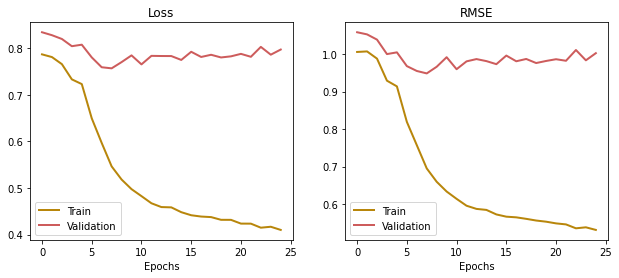

In [19]:
# grab history
history = hist.history

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)

plt.plot(history['loss'], lw=2, color='darkgoldenrod')
plt.plot(history['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
#plt.ylim(0.5,0.7)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss');

ax = fig.add_subplot(1, 3, 2)

plt.plot(history['root_mean_squared_error'], lw=2, color='darkgoldenrod')
plt.plot(history['val_root_mean_squared_error'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
#plt.ylim(0.5,0.7)
ax.set_xlabel('Epochs', size=10)
ax.set_title('RMSE');


In [22]:
#
model = get_model()
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("counts_2gram.keras", save_best_only=True)
]
hist = model.fit(
    x=all_train_features_ds,
    y=all_train_targets_ds,
    validation_data = None,
    epochs=10,
    callbacks=callbacks
)


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
tf.one_hot_8 (TFOpLambda)    (None, None, 20000)       0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                5128448   
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 390       
Total params: 5,128,838
Trainable params: 5,128,838
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
123/123 [==============================] - 29s 218ms/step - loss: 0.7840 - root_mean_squared_error: 1.00

## Submission to contest

In [23]:
test_predictions = model.predict(all_test_features_ds)
test_predictions = pd.DataFrame(all_sc_y.inverse_transform(test_predictions))

test_from_comp['cohesion'] = test_predictions[0]
test_from_comp['syntax'] = test_predictions[1]
test_from_comp['vocabulary'] = test_predictions[2]
test_from_comp['phraseology'] = test_predictions[3]
test_from_comp['grammar'] = test_predictions[4]
test_from_comp['conventions'] = test_predictions[5]
test_from_comp

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,when a person has no experience on a job their...,2.949366,2.870633,3.128393,2.974933,2.811964,2.892401
1,000BAD50D026,Do you think students would benefit from being...,2.849380,2.726063,2.958613,2.789016,2.671189,2.803100
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde...",3.184147,3.092349,3.280822,3.189639,3.116464,3.129941


In [24]:
res = test_from_comp.drop("full_text",axis=1)
res.to_csv("/kaggle/working/submission.csv",index=False)